In [1]:
import os
import traceback
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import time
import scienceplots
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Extraction function
def tflog2pandas(path):
    runlog_data = pd.DataFrame({"metric": [], "value": [], "step": []})
    try:
        event_acc = EventAccumulator(path)
        event_acc.Reload()
        tags = event_acc.Tags()["scalars"]
        for tag in tags:
            event_list = event_acc.Scalars(tag)
            values = list(map(lambda x: x.value, event_list))
            step = list(map(lambda x: x.step, event_list))
            r = {"metric": [tag] * len(step), "value": values, "step": step}
            r = pd.DataFrame(r)
            runlog_data = pd.concat([runlog_data, r])
    # Dirty catch of DataLossError
    except Exception:
        print("Event file possibly corrupt: {}".format(path))
        traceback.print_exc()
    return runlog_data

In [2]:
# PLOT SETTINGS

# plt.rcParams["font.family"] = "sans-serif"
plt.style.use(["science", "no-latex"])
# plt.style.use(["science"])
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["axes.spines.right"] = True
plt.rcParams["axes.spines.top"] = True
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42
# plt.rcParams["figure.autolayout"] = True
# plt.rcParams["legend.frameon"] = False


def add_custom_ylabel(ax, label, x_offset=0, y_offset=1.02):
    ax.annotate(
        label,
        xy=(x_offset, y_offset),
        xycoords="axes fraction",
        rotation=0,
        ha="center",
        va="bottom",
    )


def save(figure, name):
    # Do not emit a creation date, creator name, or producer. This will make the
    # content of the pdfs we generate more deterministic.
    metadata = {"CreationDate": None, "Creator": None, "Producer": None}
    figure.savefig(name, metadata=metadata)
    # Close figure to avoid warning about too many open figures.
    plt.close(figure)
    print(f"written to {name}")

In [6]:
tb_filepaths:list[str] = []
for root, dirs, files in os.walk("log"):
    for file in files:
        if file.startswith("events.out"):
            root = root.replace('\\', '/')
            tb_filepaths.append(root)

def make_csv(tb_path: list[str]) -> None:
    for path in tb_path:
        df = tflog2pandas(path)
        csv_name = f"{path.split('/')[-1]}.csv"
        csv_path = os.path.join(path, csv_name)
        df.to_csv(csv_path)

make_csv(tb_filepaths)

csv_paths:list[str] = []

for root, dirs, files in os.walk("log"):
    for file in files:
        if file.endswith(".csv"):
            path = os.path.join(root, file).replace("\\", "/")
            csv_paths.append(path)

def load_csv_data(csv_path:str) -> pd.DataFrame:
    data = pd.read_csv(csv_path)

    data = data.drop(columns=["Unnamed: 0"])

    # Pivot the dataframe to have metrics as separate columns
    pivoted_data = data.pivot(index="step", columns="metric", values="value")

    pivoted_data.columns = [col for col in pivoted_data.columns]
    pivoted_data = pivoted_data.reset_index()
    # print([col for col in pivoted_data.columns])

    data = data.drop(columns=["step"])


    # pivoted_data = pivoted_data[
    #     [
    #         "training_loss",
    #         "validation_loss",
    #         "perplexity",
    #         "hellaswag_accuracy",
    #         "norm",
    #         "dt",
    #         "tok/sec",
    #         "elapsed_time",
    #     ]
    # ]

    # every value in elapsed_time column = time.strftime('%H:%M:%S', time.gmtime(item))
    pivoted_data["elapsed_time"] = [
        time.strftime("%H:%M:%S", time.gmtime(item))
        for item in pivoted_data["elapsed_time"]
    ]

    return pivoted_data


In [7]:
df = load_csv_data(csv_paths[0])
df.head()

,step,accuracy,bleu_score,dt,elapsed_time,hellaswag_accuracy,learning_rate,norm,perplexity,tok/sec,training_loss,validation_loss
0,0.0,0.000037,0.002013,30703.199219,00:00:30,0.246664,8.391609e-07,2.9089,1.725234,4269.000000,10.921947,10.907251
1,1.0,NaN,NaN,24891.880859,00:02:20,NaN,1.678322e-06,2.9494,NaN,5265.649902,10.919794,NaN
2,2.0,NaN,NaN,24845.619141,00:02:44,NaN,2.517482e-06,2.9121,NaN,5275.459961,10.910027,NaN
3,3.0,NaN,NaN,21717.289062,00:03:06,NaN,3.356643e-06,2.9089,NaN,6035.379883,10.905201,NaN
4,4.0,NaN,NaN,22490.769531,00:03:29,NaN,4.195804e-06,2.8855,NaN,5827.810059,10.895893,NaN


In [46]:
import re
def extract_model_name(csv_path:str) -> str | None:
    # Use regex to find the model name
    match = re.search(r'/([^/]+?)(?:_\d{8}-\d{6})/', csv_path)
    if match:
        return match.group(1)
    return None

# width, height = plt.rcParams.get("figure.figsize")
figsize = plt.rcParams.get("figure.figsize")
if figsize is not None:
    width, height = figsize
else:
    width, height = (6, 4)  # default values

init_step = 0

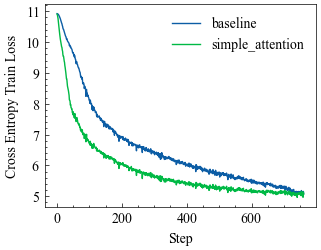

written to images/train_loss_models.pdf


In [47]:
fig, ax = plt.subplots(figsize=(width, height))

for csv in csv_paths:
    data = load_csv_data(csv)
    model_name = extract_model_name(csv)

    sns.lineplot(
        data=data[init_step:],
        x=data.index[init_step:],
        y="training_loss",
        label= model_name,
        ax=ax,
    )

ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
# plt.tick_params(axis="both", which="both", length=0)
# plt.yscale("log")
plt.legend()
ax.set_ylabel("Cross Entropy Train Loss")
ax.set_xlabel("Step")
plt.show()
save(fig, "images/train_loss_models.pdf")

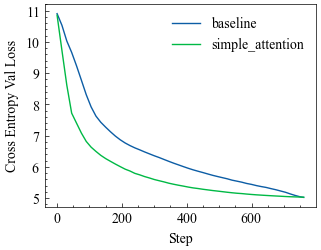

written to images/val_loss_models.pdf


In [48]:
fig, ax = plt.subplots(figsize=(width, height))

for csv in csv_paths:
    data = load_csv_data(csv)
    # model_name = f"{(csv.split('/')[-1]).split('_')[:-1]}"
    model_name = extract_model_name(csv)

    sns.lineplot(
        data=data[init_step:],
        x=data.index[init_step:],
        y="validation_loss",
        label= model_name,
        ax=ax,
    )

ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
# plt.tick_params(axis="both", which="both", length=0)
# plt.yscale("log")
# ax.legend(title='Models')
# ax.autoscale(tight=True)
ax.set_ylabel("Cross Entropy Val Loss")
ax.set_xlabel("Step")
plt.show()
save(fig, "images/val_loss_models.pdf")

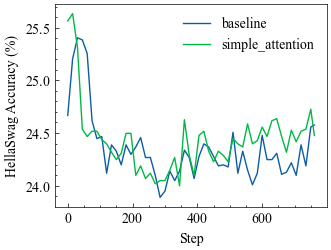

written to images/hellaswag_models.pdf


In [49]:
fig, ax = plt.subplots(figsize=(width, height))

for csv in csv_paths:
    data = load_csv_data(csv)
    # model_name = f"{(csv.split('/')[-1]).split('_')[:-1]}"
    model_name = extract_model_name(csv)

    sns.lineplot(
        data=data[init_step:] * 100,
        x=data.index[init_step:],
        y="hellaswag_accuracy",
        label= model_name,
        ax=ax,
    )

ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
# plt.tick_params(axis="both", which="both", length=0)
# plt.yscale("log")
# ax.legend(title='Models')
# ax.autoscale(tight=True)
ax.set_ylabel("HellaSwag Accuracy (%)")
ax.set_xlabel("Step")
plt.show()
save(fig, "images/hellaswag_models.pdf")

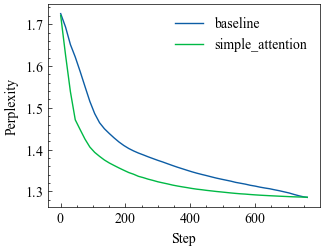

written to images/perplexity_models.pdf


In [50]:
fig, ax = plt.subplots(figsize=(width, height))

for csv in csv_paths:
    data = load_csv_data(csv)
    # model_name = f"{(csv.split('/')[-1]).split('_')[:-1]}"
    model_name = extract_model_name(csv)

    sns.lineplot(
        data=data[init_step:],
        x=data.index[init_step:],
        y="perplexity",
        label= model_name,
        ax=ax,
    )

ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
# plt.tick_params(axis="both", which="both", length=0)
# plt.yscale("log")
# ax.legend(title='Models')
# ax.autoscale(tight=True)
ax.set_ylabel("Perplexity")
ax.set_xlabel("Step")
plt.show()
save(fig, "images/perplexity_models.pdf")

In [51]:
metrics_df = pd.DataFrame()

for csv in csv_paths:
    data = load_csv_data(csv)
    model_name = extract_model_name(csv)
    row = data.iloc[[-1]].copy()

    row.loc[:, 'model'] = model_name

    metrics_df = pd.concat([metrics_df, row], ignore_index=True)

metrics_df


,training_loss,validation_loss,perplexity,hellaswag_accuracy,norm,dt,tok/sec,elapsed_time,model
0,5.082212,5.026562,1.285732,0.245768,0.4746,12239.419922,10709.000000,04:59:05,baseline
1,5.069296,5.032745,1.286129,0.244772,0.4686,14845.549805,8829.049805,05:09:46,simple_attention
